## Building Flexible Audio DDSP Pipelines: A Case Study on Artificial Reverb
**DAFx25 Tutorial - September 2, 2025**  
*International Conference on Digital Audio Effects DAFx, Ancona (IT)*

### Parametric Equalizer (PEQ) Parameter Optimization

This notebook demonstrates how to build and optimize a differentiable Parametric Equalizer (PEQ) to match a target frequency response. The tutorial covers:

- Creating a target PEQ with known parameters
- Setting up an optimization pipeline to learn PEQ parameters
- Training the model to match the target frequency response
- Analyzing and comparing the learned parameters with the target

In [2]:
# --- Imports ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from pathlib import Path
from flamo.optimize.dataset import Dataset, load_dataset 
from flamo.optimize.trainer import Trainer
from flamo.processor import dsp, system
from flamo.functional import signal_gallery

# --- Device Configuration ---
torch.set_default_dtype(torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Audio Configuration ---
fs = 48000          # Sampling rate
nfft = 96000        # FFT size for frequency domain processing


Using device: cpu


### Target PEQ Creation

Create a target parametric equalizer with known parameters that our model should learn to match.

PEQ Configuration: 7 bands, 1 input → 2 output channels
Target frequency response shape: torch.Size([1, 48001, 2])


/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/conferences/dafx25/dafx25-ddsp-tutorial/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/conferences/dafx25/dafx25-ddsp-tutorial/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


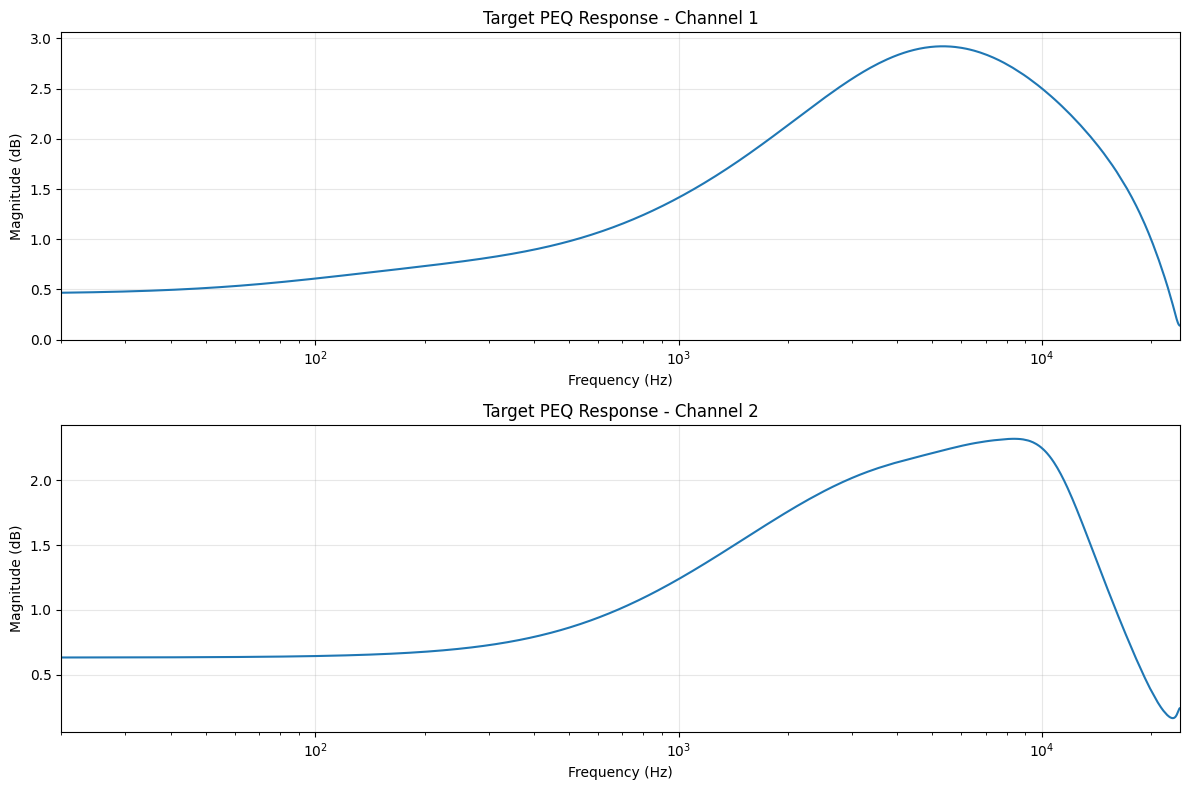

In [3]:

# --- Target PEQ Configuration ---
in_ch, out_ch = 1, 2        # Input and output channels
n_bands = 7                 # Number of parametric EQ bands

print(f"PEQ Configuration: {n_bands} bands, {in_ch} input → {out_ch} output channels")

# --- Create Target PEQ ---
# Initialize the target PEQ with random parameters
target_peq = dsp.PEQ(
    size=(out_ch, in_ch),
    n_bands=n_bands,
    nfft=nfft,
    fs=fs,
    requires_grad=True,
    alias_decay_db=0,
    device=device,
)

# --- Create Target Model with Shell ---
# The Shell wraps the PEQ core with input/output layers
input_layer = dsp.FFT(nfft) 
output_layer = dsp.Transform(transform=lambda x: torch.abs(x))  # Magnitude extraction
target_model = system.Shell(core=target_peq, input_layer=input_layer, output_layer=output_layer)

# Get the target frequency response
target_response = target_model.get_freq_response(identity=True)
print(f"Target frequency response shape: {target_response.shape}")

# --- Visualize Target Response ---
freq_bins = np.linspace(0, fs/2, target_response.shape[1])

plt.figure(figsize=(12, 8))
for ch in range(out_ch):
    plt.subplot(2, 1, ch+1)
    plt.plot(freq_bins, 20*np.log10(target_response[0, :, ch].detach().numpy()))
    plt.title(f"Target PEQ Response - Channel {ch+1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.xlim([20, fs/2])

plt.tight_layout()
plt.show()


### Learnable PEQ Model Setup

Create the PEQ model that will be optimized to match the target response.

Initial learnable response shape: torch.Size([1, 48001, 2])


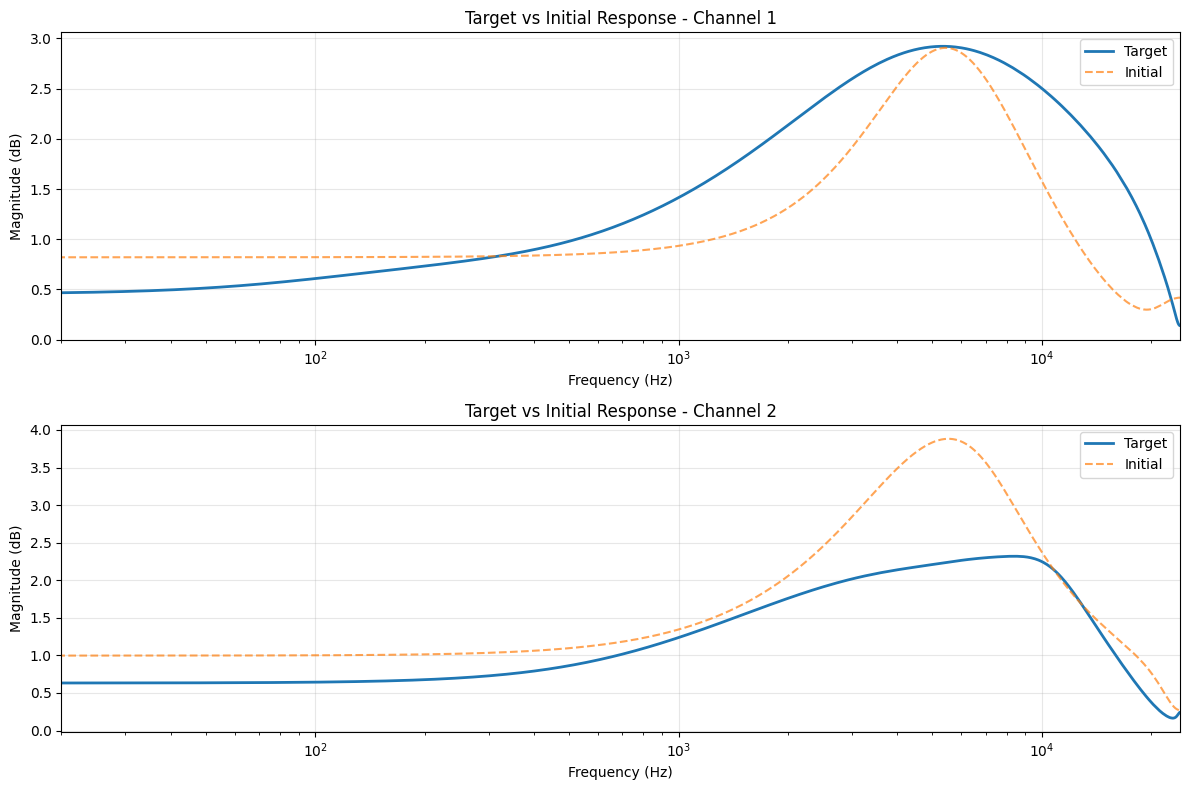

In [4]:
# --- Create Learnable PEQ ---
# Initialize a new PEQ with random parameters (different from target)
learnable_peq = dsp.PEQ(
    size=(out_ch, in_ch),
    n_bands=n_bands,
    nfft=nfft,
    fs=fs,
    requires_grad=True,
    alias_decay_db=0,
    device=device,
)

# --- Create Learnable Model with Shell ---
learnable_model = system.Shell(
    core=learnable_peq, 
    input_layer=input_layer, 
    output_layer=output_layer
)

# Get initial frequency response before optimization
initial_response = learnable_model.get_freq_response()
print(f"Initial learnable response shape: {initial_response.shape}")

# --- Compare Initial vs Target Response ---
plt.figure(figsize=(12, 8))
for ch in range(out_ch):
    plt.subplot(2, 1, ch+1)
    plt.plot(freq_bins, 20*np.log10(target_response[0, :, ch].detach().numpy()), 
             label="Target", linewidth=2)
    plt.plot(freq_bins, 20*np.log10(initial_response[0, :, ch].detach().numpy()), 
             label="Initial", linestyle='--', alpha=0.7)
    plt.title(f"Target vs Initial Response - Channel {ch+1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.xlim([20, fs/2])

plt.tight_layout()
plt.show()


### Training Setup and Optimization

Configure the training pipeline to optimize the PEQ parameters to match the target response.

In [5]:
# --- Create Training Input ---
# Use impulse signal for system identification
input_signal = signal_gallery(
    1, 
    n_samples=nfft, 
    n=in_ch, 
    signal_type="impulse", 
    fs=fs
)

# --- Dataset Creation ---
# Create dataset with input-target pairs
dataset = Dataset(
    input=input_signal,
    target=torch.abs(target_response),
    expand=256,  # Number of training iterations
    device=device,
)
train_loader, valid_loader = load_dataset(dataset, batch_size=1)
print(f"Dataset created with {len(dataset)} samples")

# --- Trainer Configuration ---
max_epochs = 25
trainer = Trainer(
    learnable_model,
    max_epochs=max_epochs,
    lr=1e-4,                    # Learning rate
    step_size=25,               # Learning rate scheduler step size
    train_dir=str(Path("../../data/results")),  # Directory for saving results
    patience_delta=1e-5,        # Early stopping threshold
    device=device,
)

# --- Register Loss Function ---
# Use Mean Squared Error to match the target frequency response
trainer.register_criterion(nn.MSELoss(), alpha=1.0)

Dataset created with 256 samples


In [6]:
# --- Start Training ---
print("Starting PEQ parameter optimization...")
trainer.train(train_loader, valid_loader)
print("Training completed!")

Starting PEQ parameter optimization...


Training:   4%|▍         | 1/25 [00:11<04:38, 11.59s/it]

epoch:   0 - train_loss: 0.0107 - test_loss: 0.0097 - time: 11.5645 s


Training:   8%|▊         | 2/25 [00:23<04:27, 11.63s/it]

epoch:   1 - train_loss: 0.0088 - test_loss: 0.0079 - time: 11.6468 s


Training:  12%|█▏        | 3/25 [00:34<04:15, 11.59s/it]

epoch:   2 - train_loss: 0.0072 - test_loss: 0.0066 - time: 11.5358 s


Training:  16%|█▌        | 4/25 [00:46<04:02, 11.57s/it]

epoch:   3 - train_loss: 0.0060 - test_loss: 0.0055 - time: 11.5176 s


Training:  20%|██        | 5/25 [00:57<03:51, 11.56s/it]

epoch:   4 - train_loss: 0.0051 - test_loss: 0.0047 - time: 11.5311 s


Training:  24%|██▍       | 6/25 [01:09<03:39, 11.58s/it]

epoch:   5 - train_loss: 0.0043 - test_loss: 0.0040 - time: 11.6093 s


Training:  28%|██▊       | 7/25 [01:21<03:28, 11.57s/it]

epoch:   6 - train_loss: 0.0037 - test_loss: 0.0034 - time: 11.5414 s


Training:  32%|███▏      | 8/25 [01:32<03:16, 11.56s/it]

epoch:   7 - train_loss: 0.0032 - test_loss: 0.0030 - time: 11.5440 s


Training:  36%|███▌      | 9/25 [01:44<03:05, 11.57s/it]

epoch:   8 - train_loss: 0.0027 - test_loss: 0.0025 - time: 11.5672 s


Training:  40%|████      | 10/25 [01:55<02:52, 11.47s/it]

epoch:   9 - train_loss: 0.0023 - test_loss: 0.0022 - time: 11.2536 s


Training:  44%|████▍     | 11/25 [02:06<02:38, 11.34s/it]

epoch:  10 - train_loss: 0.0020 - test_loss: 0.0018 - time: 11.0171 s


Training:  48%|████▊     | 12/25 [02:18<02:28, 11.42s/it]

epoch:  11 - train_loss: 0.0017 - test_loss: 0.0015 - time: 11.6097 s


Training:  52%|█████▏    | 13/25 [02:29<02:17, 11.49s/it]

epoch:  12 - train_loss: 0.0014 - test_loss: 0.0013 - time: 11.6242 s


Training:  56%|█████▌    | 14/25 [02:41<02:06, 11.52s/it]

epoch:  13 - train_loss: 0.0012 - test_loss: 0.0012 - time: 11.5918 s


Training:  60%|██████    | 15/25 [02:52<01:55, 11.55s/it]

epoch:  14 - train_loss: 0.0011 - test_loss: 0.0010 - time: 11.6004 s


Training:  64%|██████▍   | 16/25 [03:04<01:44, 11.56s/it]

epoch:  15 - train_loss: 0.0009 - test_loss: 0.0009 - time: 11.5836 s


Training:  68%|██████▊   | 17/25 [03:16<01:32, 11.56s/it]

epoch:  16 - train_loss: 0.0008 - test_loss: 0.0008 - time: 11.5348 s


Training:  72%|███████▏  | 18/25 [03:27<01:20, 11.54s/it]

epoch:  17 - train_loss: 0.0007 - test_loss: 0.0007 - time: 11.5047 s


Training:  76%|███████▌  | 19/25 [03:39<01:09, 11.55s/it]

epoch:  18 - train_loss: 0.0006 - test_loss: 0.0006 - time: 11.5752 s


Training:  80%|████████  | 20/25 [03:50<00:57, 11.56s/it]

epoch:  19 - train_loss: 0.0005 - test_loss: 0.0005 - time: 11.5517 s


Training:  84%|████████▍ | 21/25 [04:02<00:46, 11.58s/it]

epoch:  20 - train_loss: 0.0005 - test_loss: 0.0004 - time: 11.6139 s


Training:  88%|████████▊ | 22/25 [04:13<00:34, 11.58s/it]

epoch:  21 - train_loss: 0.0004 - test_loss: 0.0004 - time: 11.5919 s


Training:  92%|█████████▏| 23/25 [04:25<00:23, 11.58s/it]

epoch:  22 - train_loss: 0.0003 - test_loss: 0.0003 - time: 11.5660 s


Training:  96%|█████████▌| 24/25 [04:36<00:11, 11.45s/it]

epoch:  23 - train_loss: 0.0003 - test_loss: 0.0003 - time: 11.1413 s


Training: 100%|██████████| 25/25 [04:48<00:00, 11.54s/it]

epoch:  24 - train_loss: 0.0002 - test_loss: 0.0002 - time: 11.8963 s
Training time: 288.594s
Training completed!


### Results Analysis

Analyze the optimization results and compare the learned PEQ response with the target.

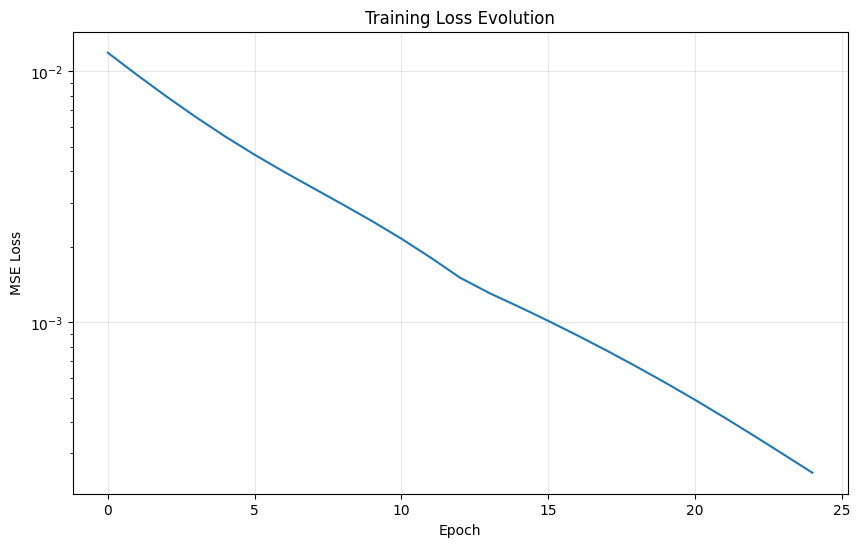

Optimized response shape: torch.Size([1, 48001, 2])


/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/conferences/dafx25/dafx25-ddsp-tutorial/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/conferences/dafx25/dafx25-ddsp-tutorial/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


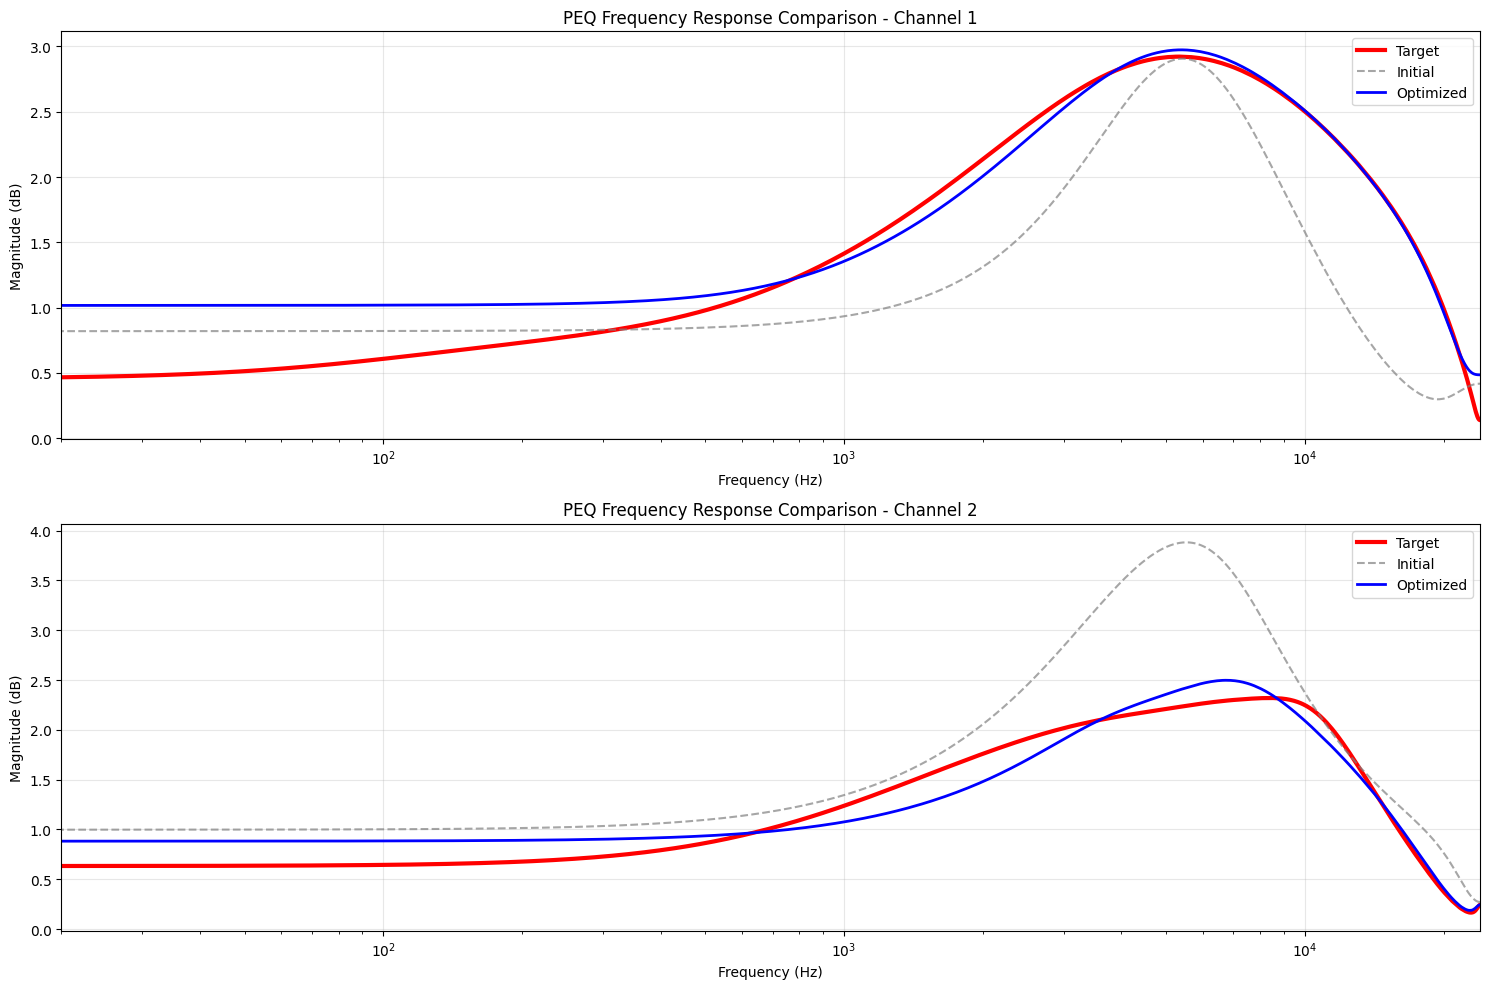

Final MSE Error: 0.000212
Final MAE Error: 0.009821
Channel 1 - Max Error: 0.56 dB, Mean Error: 0.08 dB
Channel 2 - Max Error: 0.29 dB, Mean Error: 0.15 dB


In [7]:
# --- Training Loss Visualization ---
plt.figure(figsize=(10, 6))
train_losses = trainer.train_loss_log['MSELoss']
n_steps = len(train_losses)
epoch_losses = train_losses[::n_steps // max_epochs]
plt.plot(epoch_losses)
plt.title("Training Loss Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# --- Get Optimized Response ---
optimized_response = learnable_model.get_freq_response()
print(f"Optimized response shape: {optimized_response.shape}")

# --- Compare All Responses ---
plt.figure(figsize=(15, 10))
for ch in range(out_ch):
    plt.subplot(2, 1, ch+1)
    
    # Plot all three responses
    plt.plot(freq_bins, 20*np.log10(target_response[0, :, ch].detach().numpy()), 
             label="Target", linewidth=3, color='red')
    plt.plot(freq_bins, 20*np.log10(initial_response[0, :, ch].detach().numpy()), 
             label="Initial", linestyle='--', alpha=0.7, color='gray')
    plt.plot(freq_bins, 20*np.log10(optimized_response[0, :, ch].detach().numpy()), 
             label="Optimized", linestyle='-', linewidth=2, color='blue')
    
    plt.title(f"PEQ Frequency Response Comparison - Channel {ch+1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.xlim([20, fs/2])
#     plt.ylim([-10, 10])

plt.tight_layout()
plt.show()

# --- Calculate and Display Error Metrics ---
mse_error = nn.MSELoss()(torch.abs(optimized_response), torch.abs(target_response))
mae_error = nn.L1Loss()(torch.abs(optimized_response), torch.abs(target_response))

print(f"Final MSE Error: {mse_error.item():.6f}")
print(f"Final MAE Error: {mae_error.item():.6f}")

# Calculate frequency-wise error for each channel
for ch in range(out_ch):
    target_db = 20*np.log10(target_response[0, :, ch].detach().numpy())
    optimized_db = 20*np.log10(optimized_response[0, :, ch].detach().numpy())
    max_error = np.max(np.abs(target_db - optimized_db))
    mean_error = np.mean(np.abs(target_db - optimized_db))
    print(f"Channel {ch+1} - Max Error: {max_error:.2f} dB, Mean Error: {mean_error:.2f} dB") 